# Capstone Project
## Image classifier for the SVHN dataset
### Instructions

In this notebook, you will create a neural network that classifies real-world images digits. You will use concepts from throughout this course in building, training, testing, validating and saving your Tensorflow classifier model.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (you could download the notebook with File -> Download .ipynb, open the notebook locally, and then File -> Download as -> PDF via LaTeX), and then submit this pdf for review.

### Let's get started!

We'll start by running some imports, and loading the dataset. For this project you are free to make further imports throughout the notebook as you wish. 

In [ ]:
import tensorflow as tf
from scipy.io import loadmat
import tensorflow as tf
from tensorflow.keras.models import Sequential , load_model
from tensorflow.keras.layers import Dense , Flatten ,Conv2D , MaxPool2D , Dropout , BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint , EarlyStopping
from sklearn.preprocessing import OneHotEncoder
from scipy.io import loadmat
import matplotlib.pyplot as plt
import random
import numpy as np


For the capstone project, you will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images.

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

The train and test datasets required for this project can be downloaded from [here](http://ufldl.stanford.edu/housenumbers/train.tar.gz) and [here](http://ufldl.stanford.edu/housenumbers/test.tar.gz). Once unzipped, you will have two files: `train_32x32.mat` and `test_32x32.mat`. You should store these files in Drive for use in this Colab notebook.

Your goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [ ]:
# Run this cell to connect to your Drive folder

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Load the dataset from your Drive folder

train = loadmat('gdrive/My Drive/MyShares/SVHN data set/train_32x32.mat')
test = loadmat('gdrive/My Drive/MyShares/SVHN data set/test_32x32.mat')

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

# New Section

## 1. Inspect and preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. _Hint: retain the channel dimension, which will now have size 1._
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.

In [ ]:
x_train = train["X"]
y_train = train["y"]
x_test = test["X"]
y_test = test["y"]
x_train.shape , y_train.shape

((32, 32, 3, 73257), (73257, 1))

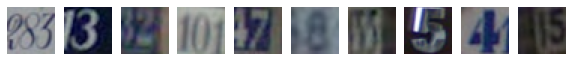

In [ ]:
fig , ax = plt.subplots(1, 10 , figsize = (10 , 2))
for i in range(10):
    
    ax[i].set_axis_off()
    sample = random.randint(1 , x_train.shape[3])
    ax[i].imshow(x_train[...,sample])

In [ ]:
x_train_greyScale = np.average(x_train, axis=2)
x_train_greyScale = np.expand_dims(x_train_greyScale, axis=2)
x_test_greyScale = np.average(x_test, axis=2)
x_test_greyScale = np.expand_dims(x_test_greyScale, axis=2)
#train_x_greyScale.shape
x_train_greyScale = np.transpose(x_train_greyScale, (3, 0, 1, 2))
x_test_greyScale = np.transpose(x_test_greyScale , (3, 0, 1, 2))

print(x_train_greyScale.shape)

print(x_test_greyScale.shape)            

enc = OneHotEncoder().fit(y_train)
y_train_oh = enc.transform(y_train).toarray()
y_test_oh = enc.transform(y_test).toarray()
print(y_train_oh.shape)               # (train_x_greyScale , train_y_onehot) training 
                                     # (test_x_greyScale , test_y_onehot)  testing

(73257, 32, 32, 1)
(26032, 32, 32, 1)
(73257, 10)


[9]
[3]
[1]
[4]
[6]
[2]
[2]
[1]
[10]
[4]


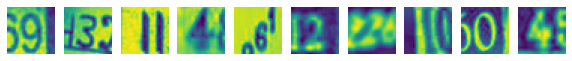

In [ ]:
 fig , ax = plt.subplots(1, 10 , figsize = (10 , 2))

for i in range(10):
    ax[i].set_axis_off()
    sample = random.randint(1 , x_train.shape[3])
  #print(sample.shape)
    print(y_train[sample])
    ax[i].imshow(x_train_greyScale[sample , ... ,0] )

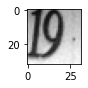

In [ ]:
fig , ax = plt.subplots(1, 1 , figsize = (1 , 1))
ax.imshow(x_train_greyScale[1 ,...,0] , cmap = plt.cm.gray)  # cmap can be added to display the image in greyscale

In [ ]:
y_train_oh[1]    

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])

## 2. MLP neural network classifier
* Build an MLP classifier model using the Sequential API. Your model should use only Flatten and Dense layers, with the final layer having a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different MLP architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 4 or 5 layers._
* Print out the model summary (using the summary() method)
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run. 
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* As a guide, you should aim to achieve a final categorical cross entropy training loss of less than 1.0 (the validation loss might be higher).
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [ ]:

def get_MLP_model():
    model = Sequential([Flatten(input_shape= [32 , 32 , 1]),
                    Dense(256 , activation = 'relu'),
                    Dense(128 , activation='relu'),
                    Dense(64  , activation = 'relu'),
                    Dense(10 , activation= 'softmax') 
                    ])
    model.compile(optimizer=tf.keras.optimizers.Adam() , 
                  loss = 'categorical_crossentropy' ,
                  metrics=['accuracy'])
    
    return model


In [ ]:
model = get_MLP_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               262400    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 304,202
Trainable params: 304,202
Non-trainable params: 0
_________________________________________________________________


In [ ]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=5 , mode='min', verbose=1)
modelCheckPoint = ModelCheckpoint(filepath="gdrive/My Drive/Colab Notebooks/CheckPoints" , save_freq="epoch"
                                  , save_weights_only=True)
modelBestWeights = ModelCheckpoint(filepath="gdrive/My Drive/Colab Notebooks/bestpoints" , save_freq="epoch"
                                  , save_weights_only=True , save_best_only = True)
callbacks = [earlyStopping , modelCheckPoint , modelBestWeights] 

In [ ]:
training_history = model.fit(x_train_greyScale , y_train_oh ,
                             validation_split=0.2 , epochs=20 ,
                             batch_size = 64 , verbose = 1 ,
                             callbacks=callbacks)

Epoch 1/20
916/916 [==============================] - 6s 7ms/step - loss: 6.1756 - accuracy: 0.1536 - val_loss: 2.5123 - val_accuracy: 0.2250
Epoch 2/20
916/916 [==============================] - 5s 6ms/step - loss: 1.9882 - accuracy: 0.3471 - val_loss: 1.7853 - val_accuracy: 0.4271
Epoch 3/20
916/916 [==============================] - 5s 5ms/step - loss: 1.5836 - accuracy: 0.4833 - val_loss: 1.5291 - val_accuracy: 0.4999
Epoch 4/20
916/916 [==============================] - 5s 5ms/step - loss: 1.4206 - accuracy: 0.5446 - val_loss: 1.3055 - val_accuracy: 0.5860
Epoch 5/20
916/916 [==============================] - 5s 5ms/step - loss: 1.3347 - accuracy: 0.5757 - val_loss: 1.3712 - val_accuracy: 0.5609
Epoch 6/20
916/916 [==============================] - 5s 5ms/step - loss: 1.2772 - accuracy: 0.5983 - val_loss: 1.3742 - val_accuracy: 0.5566
Epoch 7/20
916/916 [==============================] - 5s 5ms/step - loss: 1.2104 - accuracy: 0.6242 - val_loss: 1.1501 - val_accuracy: 0.6376
Epoch 

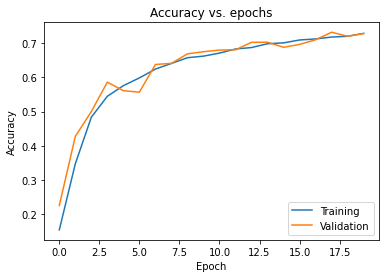

In [ ]:
try:
    plt.plot(training_history.history['accuracy'])
    plt.plot(training_history.history['val_accuracy'])
except KeyError:
    plt.plot(training_history.history['acc'])
    plt.plot(training_history.history['val_acc'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show() 

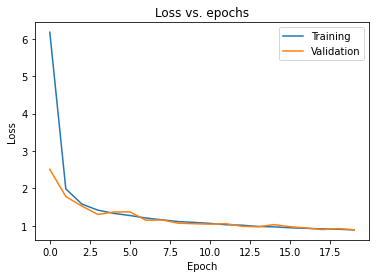

In [ ]:
plt.plot(training_history.history['loss'])
plt.plot(training_history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss') 
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

In [ ]:
test_history = model.evaluate(x_test_greyScale , y_test_oh , verbose=2)

814/814 - 1s - loss: 1.0131 - accuracy: 0.7068


## 3. CNN neural network classifier
* Build a CNN classifier model using the Sequential API. Your model should use the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer should again have a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different CNN architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 2 or 3 convolutional layers and 2 fully connected layers.)_
* The CNN model should use fewer trainable parameters than your MLP model.
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* You should aim to beat the MLP model performance with fewer parameters!
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [ ]:
def get_CNN_model():
    CNN_model = Sequential([Conv2D(16 , kernel_size = (3,3), input_shape = (32,32,1),
                                   padding = "SAME" , activation= 'relu',
                                   kernel_initializer='he_uniform'),
                            MaxPool2D(pool_size= (2,2)),
                            Flatten(),
                            Dropout(0.2),
                            BatchNormalization(),
                            Dense(64 , activation='relu'),
                            Dense (10 , activation='softmax')])
    CNN_model.compile(optimizer='adam' , loss = 'categorical_crossentropy'
                      , metrics=['accuracy'])
    
    return CNN_model

In [ ]:
model = get_CNN_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dropout (Dropout)            (None, 4096)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 4096)              16384     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                262208    
_________________________________________________________________
dense_5 (Dense)              (None, 10)               

In [ ]:
CNN_earlyStopping = EarlyStopping(monitor='val_loss', 
                                  patience=5 ,
                                  mode='min', verbose=1)
CNN_modelCheckPoint = ModelCheckpoint(filepath="gdrive/My Drive/Colab Notebooks/CheckPoints/CNNCheckPoints" ,
                                      save_freq="epoch",
                                     save_weights_only=True)
CNN_modelBestWeights = ModelCheckpoint(filepath="gdrive/My Drive/Colab Notebooks/CheckPoints/CNNbestpoints" ,
                                       save_freq="epoch",
                                      save_weights_only=True ,
                                       save_best_only = True)
CNN_callbacks = [CNN_earlyStopping , CNN_modelCheckPoint , CNN_modelBestWeights] 

In [ ]:
CNN_history = model.fit(x_train_greyScale , y_train_oh , epochs=10 ,
                            batch_size=64 , callbacks=CNN_callbacks,
                            validation_split = 0.2,
                             verbose=1) 

Epoch 1/10
916/916 [==============================] - 36s 39ms/step - loss: 1.0831 - accuracy: 0.6523 - val_loss: 0.7804 - val_accuracy: 0.7826
Epoch 2/10
916/916 [==============================] - 35s 39ms/step - loss: 0.7114 - accuracy: 0.7789 - val_loss: 0.6941 - val_accuracy: 0.8184
Epoch 3/10
916/916 [==============================] - 37s 40ms/step - loss: 0.6190 - accuracy: 0.8109 - val_loss: 0.6574 - val_accuracy: 0.8301
Epoch 4/10
916/916 [==============================] - 36s 39ms/step - loss: 0.5617 - accuracy: 0.8257 - val_loss: 0.6228 - val_accuracy: 0.8277
Epoch 5/10
916/916 [==============================] - 35s 38ms/step - loss: 0.5195 - accuracy: 0.8395 - val_loss: 0.6308 - val_accuracy: 0.8427
Epoch 6/10
916/916 [==============================] - 36s 39ms/step - loss: 0.4848 - accuracy: 0.8505 - val_loss: 0.6904 - val_accuracy: 0.8443
Epoch 7/10
916/916 [==============================] - 35s 39ms/step - loss: 0.4635 - accuracy: 0.8574 - val_loss: 0.6123 - val_accuracy:

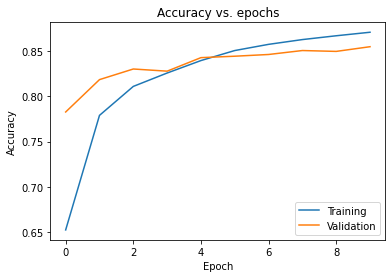

In [ ]:
try:
    plt.plot(CNN_history.history['accuracy'])
    plt.plot(CNN_history.history['val_accuracy'])
except KeyError:
    plt.plot(CNN_history.history['acc'])
    plt.plot(CNN_history.history['val_acc'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show() 

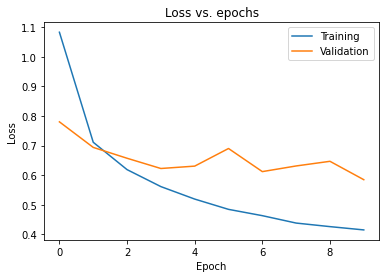

In [ ]:
plt.plot(CNN_history.history['loss'])
plt.plot(CNN_history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss') 
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

In [ ]:
CNN_test_history = model.evaluate(x_test_greyScale , y_test_oh , verbose=2)

814/814 - 5s - loss: 0.7111 - accuracy: 0.8326


## 4. Get model predictions
* Load the best weights for the MLP and CNN models that you saved during the training run.
* Randomly select 5 images and corresponding labels from the test set and display the images with their labels.
* Alongside the image and label, show each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.

In [ ]:
new_MLP_model = get_MLP_model()
new_MLP_model.load_weights("gdrive/My Drive/Colab Notebooks/bestpoints")

In [ ]:
new_MLP_model.evaluate(x_test_greyScale , y_test_oh , verbose=2)

814/814 - 1s - loss: 1.0131 - accuracy: 0.7068


[1.0130500793457031, 0.7067839503288269]

In [ ]:
new_CNN_model = get_CNN_model()
new_CNN_model.load_weights("gdrive/My Drive/Colab Notebooks/CheckPoints/CNNbestpoints")
new_CNN_model.evaluate(x_test_greyScale , y_test_oh , verbose=2)

814/814 - 5s - loss: 0.7111 - accuracy: 0.8326


[0.7111225128173828, 0.8326290845870972]

In [ ]:
num_test_images = x_test_greyScale.shape[0]

random_inx = np.random.choice(num_test_images, 5)

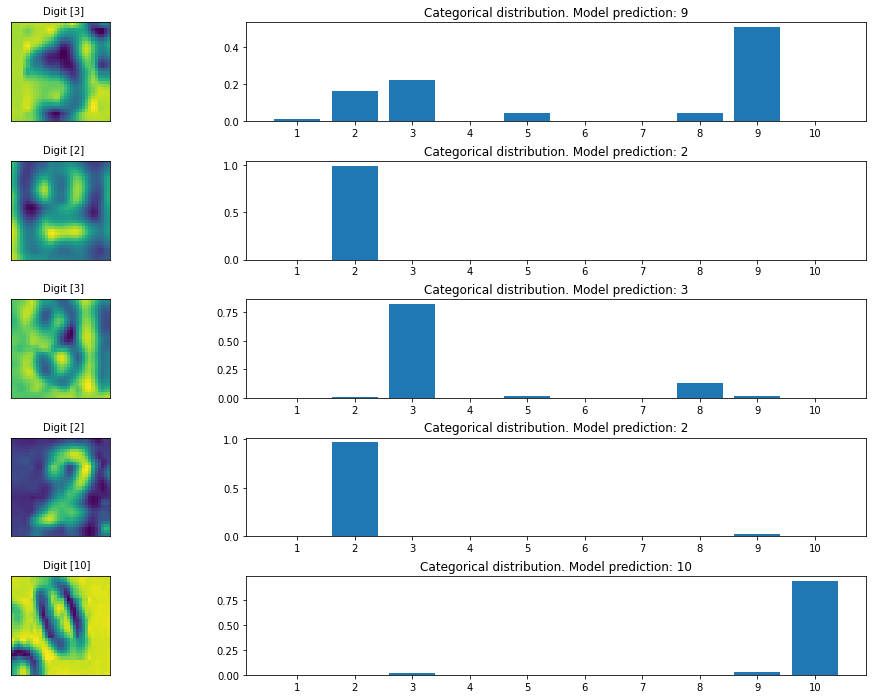

In [ ]:
# CNN model 
random_test_images = x_test_greyScale[random_inx, ...]
random_test_labels = y_test[random_inx, ...]

predictions_CNN = new_CNN_model.predict(random_test_images)

fig, axes = plt.subplots(5, 2, figsize=(20, 12))
fig.subplots_adjust(hspace=0.4, wspace=-0.2)

for i, (prediction_CNN, image, label) in enumerate(zip(predictions_CNN , random_test_images, random_test_labels)):
    axes[i, 0].imshow(np.squeeze(image))
    axes[i, 0].get_xaxis().set_visible(False)
    axes[i, 0].get_yaxis().set_visible(False)
    axes[i, 0].text(10., -3, f'Digit {label}')
    axes[i, 1].bar(np.arange(1,11), prediction_CNN)
    axes[i, 1].set_xticks(np.arange(1,11))
    axes[i, 1].set_title(f"Categorical distribution. Model prediction: {np.argmax(prediction_CNN) + 1}") 
plt.show()

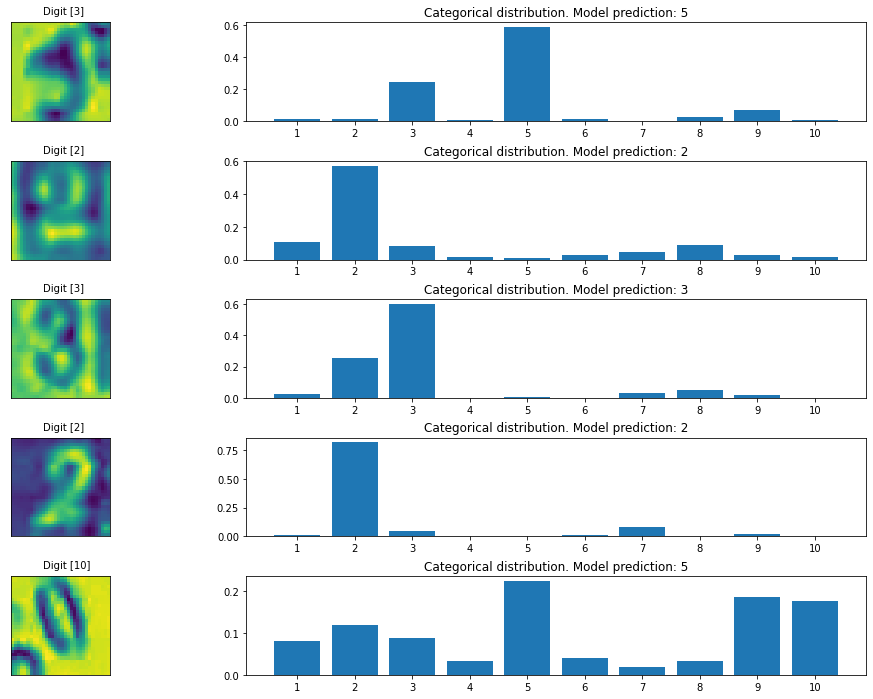

In [ ]:
# MLP model
random_test_images = x_test_greyScale[random_inx, ...]
random_test_labels = y_test[random_inx, ...]

predictions_MLP = new_MLP_model.predict(random_test_images)

fig, axes = plt.subplots(5, 2, figsize=(20, 12))
fig.subplots_adjust(hspace=0.4, wspace=-0.2)

for i, (prediction_MLP, image, label) in enumerate(zip(predictions_MLP , random_test_images, random_test_labels)):
    axes[i, 0].imshow(np.squeeze(image))
    axes[i, 0].get_xaxis().set_visible(False)
    axes[i, 0].get_yaxis().set_visible(False)
    axes[i, 0].text(10., -3, f'Digit {label}')
    axes[i, 1].bar(np.arange(1,11), prediction_MLP)
    axes[i, 1].set_xticks(np.arange(1,11))
    axes[i, 1].set_title(f"Categorical distribution. Model prediction: {np.argmax(prediction_MLP) + 1}") 
plt.show()